In [1]:
! rm -rf sample_data
! gdown --id 1LhzZ7tOZPBban3lQrwcQB07u9m3VXPVj
! unzip hamiltonian_graph_init.zip -d hamiltonian_graph_init

Streaming output truncated to the last 5000 lines.
  inflating: hamiltonian_graph_init/test_images/graph356.png  
  inflating: hamiltonian_graph_init/test_images/graph361.png  
  inflating: hamiltonian_graph_init/test_images/graph366.png  
  inflating: hamiltonian_graph_init/test_images/graph392.png  
  inflating: hamiltonian_graph_init/test_images/graph401.png  
  inflating: hamiltonian_graph_init/test_images/graph415.png  
  inflating: hamiltonian_graph_init/test_images/graph450.png  
  inflating: hamiltonian_graph_init/test_images/graph473.png  
  inflating: hamiltonian_graph_init/test_images/graph476.png  
  inflating: hamiltonian_graph_init/test_images/graph480.png  
  inflating: hamiltonian_graph_init/test_images/graph490.png  
  inflating: hamiltonian_graph_init/test_images/graph504.png  
  inflating: hamiltonian_graph_init/test_images/graph508.png  
  inflating: hamiltonian_graph_init/test_images/graph511.png  
  inflating: hamiltonian_graph_init/test_images/graph516.png  
  in

In [8]:
import torch
import torchvision
import pandas as pd
import os
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv("hamiltonian_graph_init/train_info.csv")
df

,file_name,hamiltonian
0,graph4443.png,yes
1,graph1905.png,no
2,graph7719.png,no
3,graph4902.png,no
4,graph4114.png,yes
...,...,...
4423,graph4672.png,yes
4424,graph3437.png,yes
4425,graph3649.png,no
4426,graph893.png,yes


In [10]:
df["hamiltonian"] = df["hamiltonian"].map(lambda x: 1 if x == "yes" else 0)
df

,file_name,hamiltonian
0,graph4443.png,1
1,graph1905.png,0
2,graph7719.png,0
3,graph4902.png,0
4,graph4114.png,1
...,...,...
4423,graph4672.png,1
4424,graph3437.png,1
4425,graph3649.png,0
4426,graph893.png,1


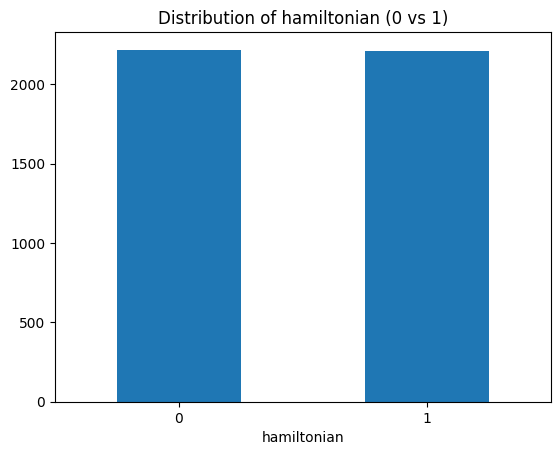

In [11]:
counts = df["hamiltonian"].value_counts()
counts.plot(kind="bar", rot=0)
plt.xlabel("hamiltonian")
plt.title("Distribution of hamiltonian (0 vs 1)")
plt.show()

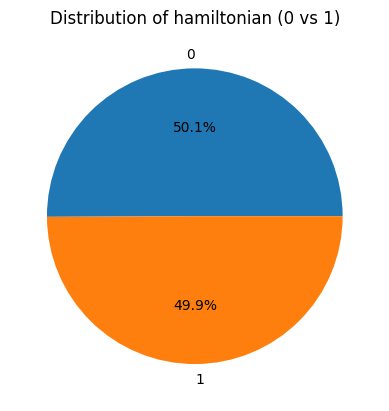

In [12]:
counts.plot(kind="pie", autopct='%1.1f%%')
plt.title("Distribution of hamiltonian (0 vs 1)")
plt.ylabel("")
plt.show()

In [13]:
test_df = pd.DataFrame({"file_name": os.listdir("hamiltonian_graph_init/test_images")})
test_df

,file_name
0,graph2026.png
1,graph4954.png
2,graph6338.png
3,graph6432.png
4,graph3736.png
...,...
1567,graph819.png
1568,graph7113.png
1569,graph2142.png
1570,graph6963.png


In [14]:
class GraphDataset(torch.utils.data.Dataset):
    def __init__(self, root_path, df, transform=None):
        self.root_path = root_path
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root_path, self.df.iloc[idx]["file_name"])).convert("RGB")
        if self.transform:
            img = self.transform(img)
        if "hamiltonian" in self.df.columns:
            label = torch.tensor(self.df.iloc[idx]["hamiltonian"], dtype=torch.float32)
            return img, label
        return img

transform = torchvision.transforms.Compose([
    torchvision.transforms.PILToTensor(),
    torchvision.transforms.Grayscale(),
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ConvertImageDtype(torch.float),
    torchvision.transforms.Lambda(lambda x: x.repeat(3,1,1))
])

dataset = GraphDataset(root_path="hamiltonian_graph_init/train_images", df=df, transform=transform)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, (0.8, 0.2))
test_dataset = GraphDataset(root_path="hamiltonian_graph_init/test_images", df=test_df, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, num_workers=2, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, num_workers=2)

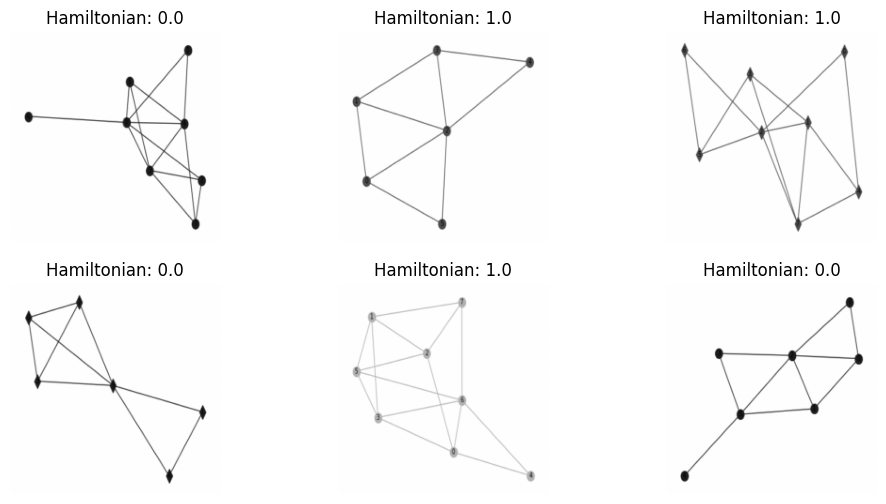

In [16]:
import matplotlib.pyplot as plt

data_iter = iter(train_loader)
images, labels = next(data_iter)

num_images = 6
plt.figure(figsize=(12, 6))

for i in range(num_images):
    img = images[i].permute(1, 2, 0)
    label = labels[i].item()
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(f"Hamiltonian: {label}")
    plt.axis('off')

plt.show()

In [18]:
!pip install timm
import timm

In [19]:
import timm
import torch.nn as nn

model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

In [20]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [22]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss /= len(train_loader.dataset)
    train_accuracy = correct / total
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)

            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct / total

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

Epoch 1/5 | Train Loss: 0.1753, Train Acc: 0.9337 | Val Loss: 0.1459, Val Acc: 0.9435
Epoch 2/5 | Train Loss: 0.1277, Train Acc: 0.9500 | Val Loss: 0.1269, Val Acc: 0.9480
Epoch 3/5 | Train Loss: 0.1130, Train Acc: 0.9582 | Val Loss: 0.3460, Val Acc: 0.8508
Epoch 4/5 | Train Loss: 0.0926, Train Acc: 0.9650 | Val Loss: 0.1704, Val Acc: 0.9266
Epoch 5/5 | Train Loss: 0.0890, Train Acc: 0.9656 | Val Loss: 0.1954, Val Acc: 0.9345


In [23]:
import torch
from sklearn.metrics import accuracy_score, f1_score

model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        outputs = model(imgs)
        preds = (torch.sigmoid(outputs) > 0.5).float()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = [int(x) for x in all_labels]
all_preds = [int(x) for x in all_preds]

acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test F1-score: {f1:.4f}")

Test Accuracy: 0.9345
Test F1-score: 0.9314


/tmp/ipython-input-958007135.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_labels = [int(x) for x in all_labels]
/tmp/ipython-input-958007135.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_preds = [int(x) for x in all_preds]


In [ ]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images in test_loader:
        images = images.to(device)

        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).long().squeeze(1)
        all_preds.append(preds.cpu())
all_preds = torch.cat(all_preds).cpu()
submission = test_df
submission["hamiltonian"] = all_preds
submission